In [7]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from matplotlib import pyplot

sns.set(style='white', context='notebook', palette='deep')

In [8]:
# MODEL REPRODUCIBLITY PARAMTERS
REPRODUCABLE_RANDOM_STATE = 9


In [9]:
df = pd.read_csv("equipfails/equip_failures_training_set.csv",na_values=["na"])

# drop id
df = df.loc[:,df.columns!='id']
df_raw = df.copy(deep=True)

In [10]:
# seperate the positive dataframe for data exploration
df_pos = df[df['target']==1]
print(df_pos.shape)

(1000, 171)


In [11]:
# features and target
X = df.drop('target',1)
y=df['target']

In [13]:
# for testing purposes, work on 20% of the data
from sklearn.model_selection import train_test_split

# stratified spliting of dataset
X_sample, _, y_sample, _ = train_test_split(X, y,
                                stratify=y, 
                                test_size=0.90,random_state=REPRODUCABLE_RANDOM_STATE)

print(y_sample.value_counts())
print(y_sample.value_counts(normalize=True))
print(y_sample.value_counts())
print(y_sample.value_counts(normalize=True))

0    5900
1     100
Name: target, dtype: int64
0    0.983333
1    0.016667
Name: target, dtype: float64
0    5900
1     100
Name: target, dtype: int64
0    0.983333
1    0.016667
Name: target, dtype: float64


In [14]:
from sklearn.model_selection import train_test_split

# stratified spliting of dataset
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample,
                                                    stratify=y_sample, 
                                                    test_size=0.25,random_state=REPRODUCABLE_RANDOM_STATE)
X_train =  X_train.copy(deep=True)
X_test = X_test.copy(deep=True)
y_train = y_train.copy(deep=True)
y_test = y_test.copy(deep=True)
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

0    4425
1      75
Name: target, dtype: int64
0    0.983333
1    0.016667
Name: target, dtype: float64
0    1475
1      25
Name: target, dtype: int64
0    0.983333
1    0.016667
Name: target, dtype: float64


In [15]:
# NA values
# get the na counts in another notebook
df_na_count = X_train.isna().sum()
df_na_count = pd.DataFrame({'feature':df_na_count.index, 'NAcount':df_na_count.values})
df_na_count['percent'] = df_na_count['NAcount']/df.shape[0]
cut = [6000*i for i in range(0,10)]
label = [str(_) for _ in cut]
df_na_count['na_bin'] = pd.cut(df_na_count['NAcount'],cut,label)
df_na_count['na_bin'].value_counts(sort=False)

(0, 6000]         169
(6000, 12000]       0
(12000, 18000]      0
(18000, 24000]      0
(24000, 30000]      0
(30000, 36000]      0
(36000, 42000]      0
(42000, 48000]      0
(48000, 54000]      0
Name: na_bin, dtype: int64

In [16]:
from collections import defaultdict

In [17]:
# preliminary handling of NA values for model comparision
missing_values = defaultdict(int)

for column in list(X_train):
    if len(X_train[column].unique()) > 100:
        val = X_train[X_train[column] != np.nan][column].mean()
        print(column,' -> mean : ',val)
    else:
        val = X_train[X_train[column] != np.nan][column].mode()
        if(val.shape):
            print(column, ' -> NaN')
            val = 0.0
        else:
            print(column,' -> mode : ',val)
    
    missing_values[column] = val 
    X_train[column].fillna(val,inplace=True)

    
# X_train.head()

sensor1_measure  -> mean :  60141.89333333333
sensor2_measure  -> NaN
sensor3_measure  -> mean :  339569166.65065914
sensor4_measure  -> mean :  437.4742722728609
sensor5_measure  -> NaN
sensor6_measure  -> NaN
sensor7_histogram_bin0  -> NaN
sensor7_histogram_bin1  -> NaN
sensor7_histogram_bin2  -> mean :  10749.368752814047
sensor7_histogram_bin3  -> mean :  78122.00045024764
sensor7_histogram_bin4  -> mean :  401441.95227375056
sensor7_histogram_bin5  -> mean :  1048834.6924808645
sensor7_histogram_bin6  -> mean :  1622746.4916704188
sensor7_histogram_bin7  -> mean :  510830.55920756416
sensor7_histogram_bin8  -> mean :  40112.469608284555
sensor7_histogram_bin9  -> mean :  3226.851418280054
sensor8_measure  -> mean :  1849751.3936122358
sensor9_measure  -> mean :  9711.55595505618
sensor10_measure  -> mean :  583.8979775280899
sensor11_measure  -> NaN
sensor12_measure  -> mean :  61530.43939734653
sensor13_measure  -> mean :  97994.26337078652
sensor14_measure  -> mean :  3516367.84

In [18]:
# fill na for the test data
for column in list(X_test):
    X_test[column].fillna(missing_values[column],inplace=True)

# X_test.head()


In [19]:
# helper functions
class model_eval:
    def __init__(self):
        self.columns = ['Model','F1','Recall','Precision','auc_score','log_loss','Brier_loss']
        new = []
        self.results = pd.DataFrame(new,columns=self.columns)
        self.precision_recall_curves = defaultdict(list)
        self.roc_curves = defaultdict(list)
        self.count = 0
        

    def add_pred(self, model_name,y_test,y_pred,y_pred_probs=[]):
        self.y_test = y_test
        self.count += 1
        values=[]
        values.append(model_name)
        values.append(metrics.f1_score(self.y_test,y_pred))
        values.append(metrics.recall_score(self.y_test,y_pred))
        values.append(metrics.precision_score(self.y_test,y_pred))
        if len(y_pred_probs):
            values.append(metrics.roc_auc_score(self.y_test,y_pred_probs[:,1]))
            values.append(metrics.log_loss(self.y_test,y_pred_probs[:,1]))
            values.append(metrics.brier_score_loss(self.y_test,y_pred_probs[:,1]))
            self.precision_recall_curves[model_name] = metrics.precision_recall_curve(self.y_test,y_pred_probs[:,1])
            self.roc_curves[model_name] = metrics.roc_curve(self.y_test,y_pred_probs[:,1])
        else:
            values.append(np.nan)
            values.append(np.nan)
            values.append(np.nan)
            
        print(values)
        self.results = self.results.append(pd.Series(values, index=self.columns, name=self.count))
    
    def show_results(self):
        return self.results
    
    def plot_roc(self):
        
        for name in self.roc_curves.keys():
            # plot the precision-recall curves
            vals = self.roc_curves[name]
            pyplot.plot(vals[0], vals[1], label=name)

        pyplot.xlabel('Specifivity')
        pyplot.ylabel('Sensitivity')
        pyplot.title('ROC')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()

    def plot_precision_recall(self):
        
        for name in self.precision_recall_curves.keys():
            # plot the precision-recall curves
            vals = self.precision_recall_curves[name]
            pyplot.plot(vals[0], vals[1], label=name)

        pyplot.xlabel('Precision')
        pyplot.ylabel('Recall')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()


    def plot_scores(self):
        sns.scatterplot(x=self.results['F1'],y=self.results['auc_score'],hue=self.results['Model'],s =500)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost

['Nearest Neighbors', 0.30769230769230765, 0.24, 0.42857142857142855, 0.8133423728813559, 0.2913525843219096, 0.013555555555555557]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


['Gaussian Process', 0.0, 0.0, 0.0, 0.5, 0.6931471708936007, 0.24999999516682767]
['Decision Tree', 0.6086956521739131, 0.56, 0.6666666666666666, 0.7353762711864407, 0.19589880757478698, 0.011228949248112064]
['Random Forest', 0.25806451612903225, 0.16, 0.6666666666666666, 0.9843525423728813, 0.040056819345975804, 0.0112959463565291]
['Neural Net', 0.4150943396226415, 0.44, 0.39285714285714285, 0.7140474576271186, 0.713810440932364, 0.020666666666666667]
['AdaBoost', 0.6521739130434783, 0.6, 0.7142857142857143, 0.9899118644067797, 0.5613008111550306, 0.18458278905491166]
['Naive Bayes', 0.4444444444444444, 0.88, 0.2972972972972973, 0.9811254237288135, 1.185964592293864, 0.036502198641135665]


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


['QDA', 0.0, 0.0, 0.0, 0.5, 0.5756462732485123, 0.016666666666666666]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['Log reg', 0.4999999999999999, 0.48, 0.5217391304347826, 0.8705898305084746, 0.09559970560189, 0.01279325423559411]
['XGBoost', 0.6666666666666665, 0.6, 0.75, 0.9932474576271187, 0.02575098217368941, 0.0072049800950023165]
                Model        F1  Recall  Precision  auc_score  log_loss  \
1   Nearest Neighbors  0.307692    0.24   0.428571   0.813342  0.291353   
2    Gaussian Process  0.000000    0.00   0.000000   0.500000  0.693147   
3       Decision Tree  0.608696    0.56   0.666667   0.735376  0.195899   
4       Random Forest  0.258065    0.16   0.666667   0.984353  0.040057   
5          Neural Net  0.415094    0.44   0.392857   0.714047  0.713810   
6            AdaBoost  0.652174    0.60   0.714286   0.989912  0.561301   
7         Naive Bayes  0.444444    0.88   0.297297   0.981125  1.185965   
8                 QDA  0.000000    0.00   0.000000   0.500000  0.575646   
9             Log reg  0.500000    0.48   0.521739   0.870590  0.095600   
10            XGBoost  0.6

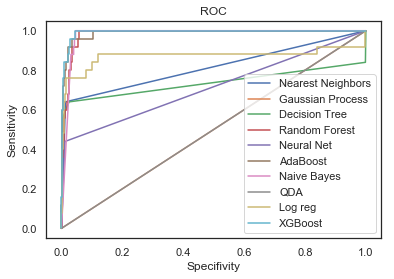

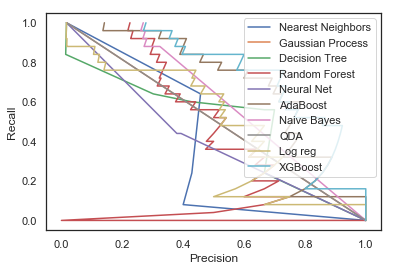

In [16]:
# do a prelimiary classification and comparision of evaluations

names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA","Log reg","XGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    GaussianProcessClassifier(1.0 * RBF(1.0),random_state=REPRODUCABLE_RANDOM_STATE),
    DecisionTreeClassifier(max_depth=5,random_state=REPRODUCABLE_RANDOM_STATE),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1,random_state=REPRODUCABLE_RANDOM_STATE),
    MLPClassifier(alpha=1, max_iter=1000,random_state=REPRODUCABLE_RANDOM_STATE),
    AdaBoostClassifier(random_state=REPRODUCABLE_RANDOM_STATE),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs',max_iter = 1000,random_state=REPRODUCABLE_RANDOM_STATE),
    xgboost.XGBClassifier(random_state=REPRODUCABLE_RANDOM_STATE)
    ]


eval_pre = model_eval()
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if "predict_proba" in dir(clf):
        y_pred_proba = clf.predict_proba(X_test)
    else:
        y_pred_proba = []
    
    eval_pre.add_pred(name,y_test,y_pred,y_pred_proba)


print(eval_pre.show_results())
eval_pre.plot_roc()
eval_pre.plot_precision_recall()

In [17]:
# increase the plot size to be more visible
plt.rcParams['figure.figsize'] = [15, 8]

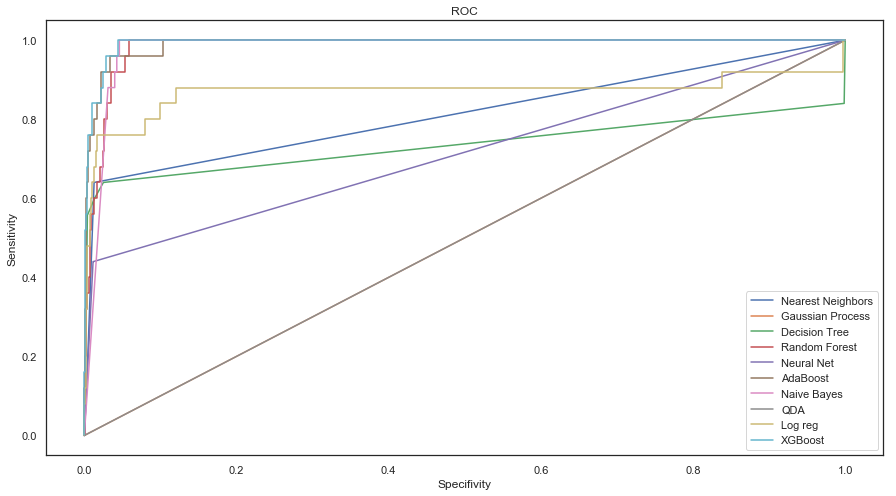

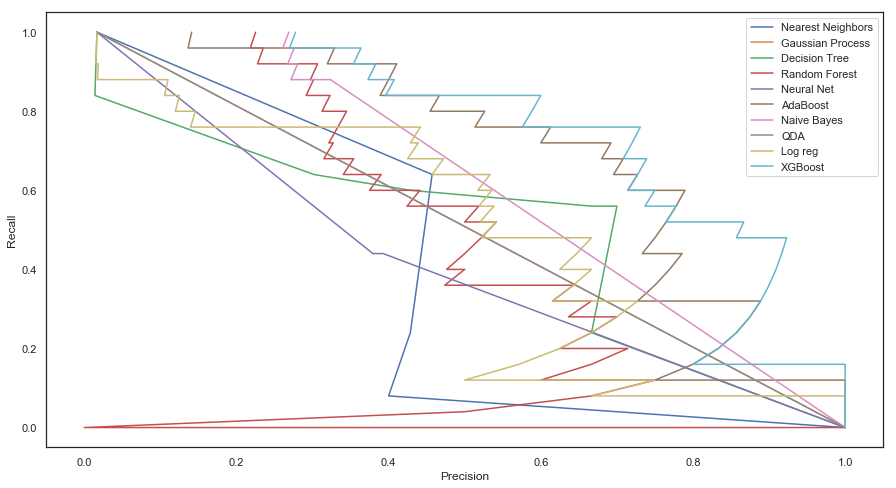

In [18]:
eval_pre.plot_roc()
eval_pre.plot_precision_recall()

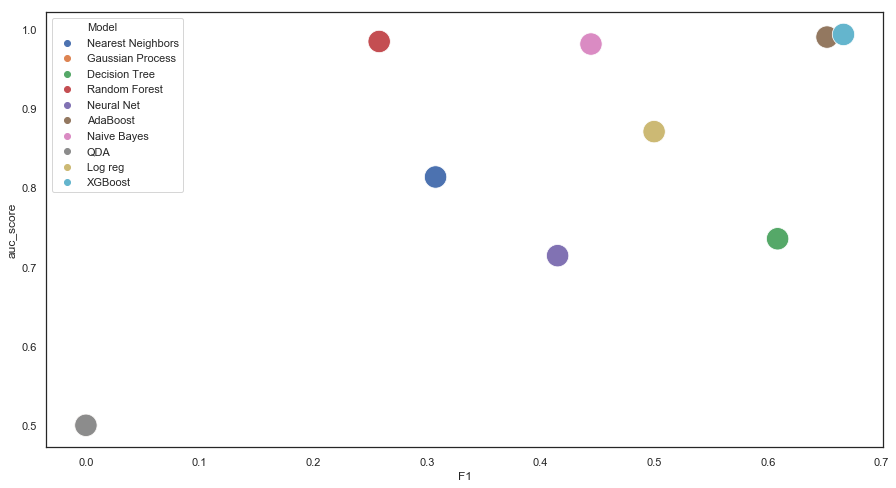

In [19]:
results_df = eval_pre.show_results()

sns.scatterplot(x=results_df['F1'],y=results_df['auc_score'],hue=results_df['Model'],s =500)


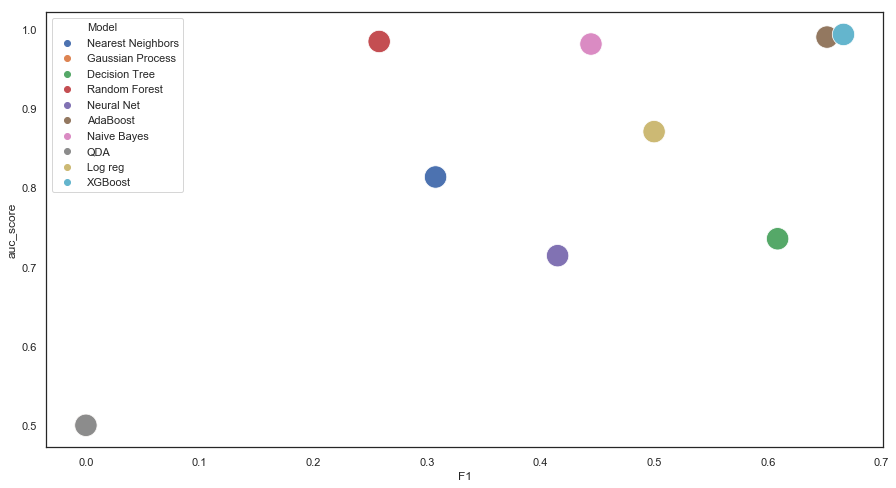

In [20]:
eval_pre.plot_scores()

# doing a grid search on log_reg and XGBoost

In [21]:
param_test = {
#  'max_delta_step':[i for i in range(0,10,1)],
#     'reg_lambda':[0,1e-3,0.1],
#     'reg_alpha':[0,1e-3,0.1],
#     'gamma':[0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00008,0.00009,0.0001]
    'max_depth' :[120,170,190],
    'min_child_weight':[0,1] 
#     'colsample_bytree':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8],
#     'subsample':[0.6,0.63,0.66,0.69,0.71,0.74,0.77,0.8]
#  'subsample':[0.84,0.85,0.86,0.87],
#  'colsample_bytree':[0.28,0.29,0.30,0.31,0.32]
}
gsearch = GridSearchCV(estimator = xgboost.XGBClassifier(eval_metric='auc',learning_rate=0.1,n_estimators=1000,
                                  colsample_bytree=0.8,subsample=0.8,colsample_bylevel=1,reg_alpha=1e-5
                                  ,base_score=0.5,scale_pos_weight=1,max_delta_step=0,reg_lambda=0
                                  ,max_depth=170, min_child_weight=0,gamma=1e-5), 
param_grid = param_test, scoring='roc_auc',iid=False, cv=3, verbose=50,n_jobs=-1)

gsearch.fit(X_train,y_train.values.ravel())

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:  1.9min remaining:   58.1s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  2.2min remaining:   50.9s
[Parallel(n_jobs=-1)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
       gamma=1e-05, learning_rate=0.1, max_delta_step=0, max_depth=170,
       min_child_weight=0, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1e-05, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': [120, 170, 190], 'min_child_weight': [0, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=50)

In [21]:
xgb_gridsearch = pd.DataFrame(gsearch.cv_results_)

NameError: name 'gsearch' is not defined

In [20]:
xgb_gridsearch

NameError: name 'xgb_gridsearch' is not defined

In [24]:
gsearch.best_params_

{'max_depth': 120, 'min_child_weight': 0}

In [25]:
param_test = {
 'max_delta_step':[i for i in range(0,10,1)],
    'reg_lambda':[0,1e-3,0.1],
    'reg_alpha':[0,1e-3,0.1],
    'gamma':[0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00008,0.00009,0.0001],
#     'max_depth' :[120,170,190],
#     'min_child_weight':[0,1] 
    'colsample_bytree':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8],
    'subsample':[0.6,0.63,0.66,0.69,0.71,0.74,0.77,0.8],
 'subsample':[0.84,0.85,0.86,0.87],
 'colsample_bytree':[0.28,0.29,0.30,0.31,0.32]
}
Rsearch = RandomizedSearchCV(estimator = xgboost.XGBClassifier(eval_metric='auc',learning_rate=0.1,n_estimators=1000,
                                  colsample_bytree=0.8,subsample=0.8,colsample_bylevel=1,reg_alpha=1e-5
                                  ,base_score=0.5,scale_pos_weight=1,max_delta_step=0,reg_lambda=0
                                  ,max_depth=170, min_child_weight=0,gamma=1e-5), 
param_distributions = param_test, scoring='roc_auc',iid=False, cv=3, verbose=50,n_jobs=-1)

Rsearch.fit(X_train,y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
       gamma=1e-05, learning_rate=0.1, max_delta_step=0, max_depth=170,
       min_child_weight=0, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1e-05, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1),
          fit_params=None, iid=False, n_iter=10, n_jobs=-1,
          param_distributions={'max_delta_step': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'reg_lambda': [0, 0.001, 0.1], 'reg_alpha': [0, 0.001, 0.1], 'gamma': [1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001], 'colsample_bytree': [0.28, 0.29, 0.3, 0.31, 0.32], 'subsample': [0.84, 0.85, 0.86, 0.87]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_t

In [26]:
Rsearch.best_score_

0.9805468926553672

In [27]:
eval_pre.show_results()

,Model,F1,Recall,Precision,auc_score,log_loss,Brier_loss
1,Nearest Neighbors,0.307692,0.24,0.428571,0.813342,0.291353,0.013556
2,Gaussian Process,0.000000,0.00,0.000000,0.500000,0.693147,0.250000
3,Decision Tree,0.608696,0.56,0.666667,0.735376,0.195899,0.011229
4,Random Forest,0.258065,0.16,0.666667,0.984353,0.040057,0.011296
5,Neural Net,0.415094,0.44,0.392857,0.714047,0.713810,0.020667
6,AdaBoost,0.652174,0.60,0.714286,0.989912,0.561301,0.184583
7,Naive Bayes,0.444444,0.88,0.297297,0.981125,1.185965,0.036502
8,QDA,0.000000,0.00,0.000000,0.500000,0.575646,0.016667
9,Log reg,0.500000,0.48,0.521739,0.870590,0.095600,0.012793
10,XGBoost,0.666667,0.60,0.750000,0.993247,0.025751,0.007205


In [28]:
eval_pre.add_pred('Logreg_na_filled',y_test,predictions,predictions_proba)

NameError: name 'predictions' is not defined

In [29]:
eval_pre.show_results()

,Model,F1,Recall,Precision,auc_score,log_loss,Brier_loss
1,Nearest Neighbors,0.307692,0.24,0.428571,0.813342,0.291353,0.013556
2,Gaussian Process,0.000000,0.00,0.000000,0.500000,0.693147,0.250000
3,Decision Tree,0.608696,0.56,0.666667,0.735376,0.195899,0.011229
4,Random Forest,0.258065,0.16,0.666667,0.984353,0.040057,0.011296
5,Neural Net,0.415094,0.44,0.392857,0.714047,0.713810,0.020667
6,AdaBoost,0.652174,0.60,0.714286,0.989912,0.561301,0.184583
7,Naive Bayes,0.444444,0.88,0.297297,0.981125,1.185965,0.036502
8,QDA,0.000000,0.00,0.000000,0.500000,0.575646,0.016667
9,Log reg,0.500000,0.48,0.521739,0.870590,0.095600,0.012793
10,XGBoost,0.666667,0.60,0.750000,0.993247,0.025751,0.007205


In [30]:
log_model = LogisticRegression(solver='lbfgs',max_iter = 2000)
log_model = log_model.fit(X_train, y_train)
predictions = log_model.predict(X_test)
predictions_proba = log_model.predict_proba(X_test)
print("Accuracy: %s%%" % (100*accuracy_score(y_test, predictions)))

Accuracy: 98.46666666666667%


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [31]:
eval_pre.add_pred('Logreg_na_filled_2000',y_test,predictions,predictions_proba)

['Logreg_na_filled_2000', 0.5306122448979592, 0.52, 0.5416666666666666, 0.7972338983050846, 0.1510024557307497, 0.01443844191451367]


In [32]:
eval_pre.show_results()

,Model,F1,Recall,Precision,auc_score,log_loss,Brier_loss
1,Nearest Neighbors,0.307692,0.24,0.428571,0.813342,0.291353,0.013556
2,Gaussian Process,0.000000,0.00,0.000000,0.500000,0.693147,0.250000
3,Decision Tree,0.608696,0.56,0.666667,0.735376,0.195899,0.011229
4,Random Forest,0.258065,0.16,0.666667,0.984353,0.040057,0.011296
5,Neural Net,0.415094,0.44,0.392857,0.714047,0.713810,0.020667
6,AdaBoost,0.652174,0.60,0.714286,0.989912,0.561301,0.184583
7,Naive Bayes,0.444444,0.88,0.297297,0.981125,1.185965,0.036502
8,QDA,0.000000,0.00,0.000000,0.500000,0.575646,0.016667
9,Log reg,0.500000,0.48,0.521739,0.870590,0.095600,0.012793
10,XGBoost,0.666667,0.60,0.750000,0.993247,0.025751,0.007205


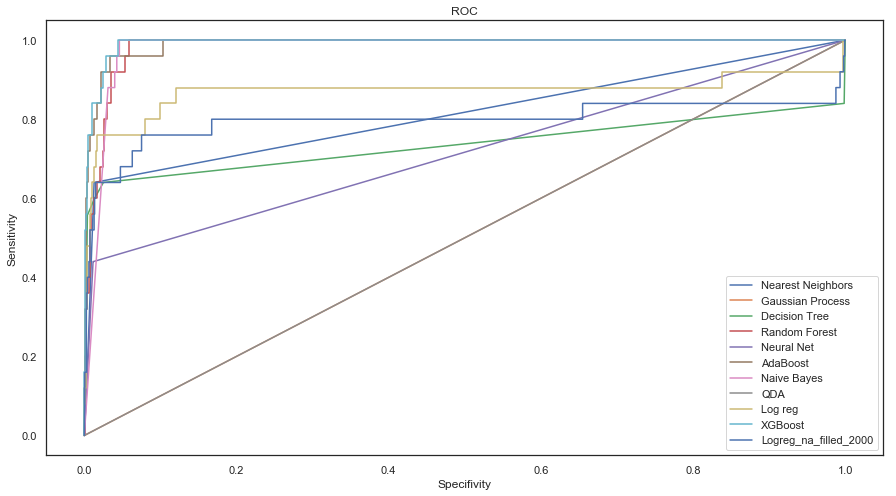

In [33]:
eval_pre.plot_roc()

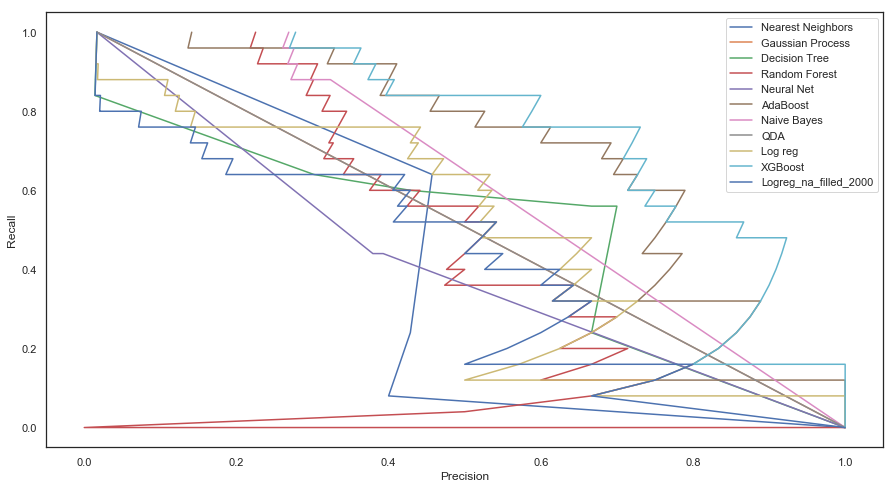

In [34]:
eval_pre.plot_precision_recall()

In [35]:
eval_pre.add_pred('Logreg_na',y_test,predictions)

['Logreg_na', 0.5306122448979592, 0.52, 0.5416666666666666, nan, nan, nan]


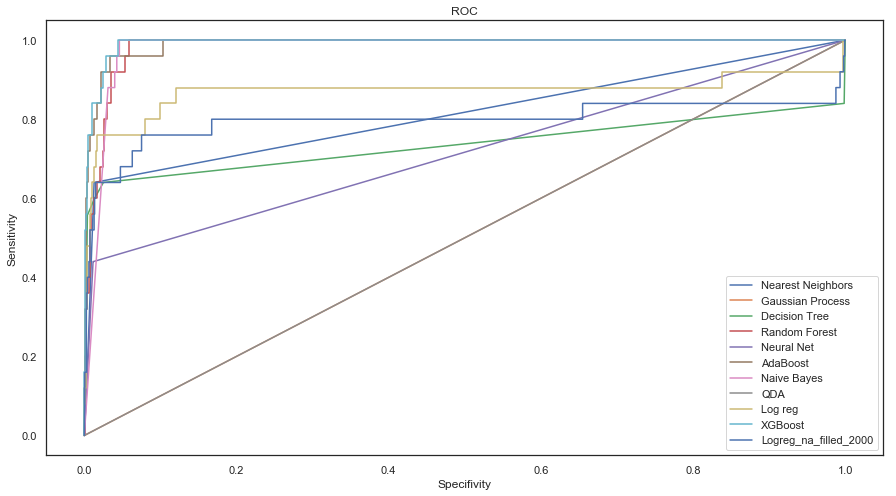

In [36]:
eval_pre.show_results()
eval_pre.plot_roc()

Series([], dtype: int64)

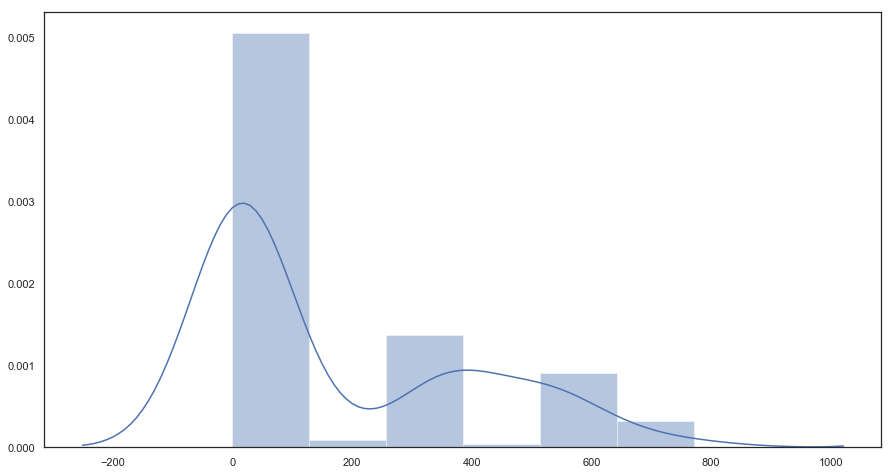

In [37]:
sns.distplot(df_pos.isna().sum(),norm_hist=False)
# which features have NA values for more than 90% +ve examples
df_pos.isna().sum()[df_pos.isna().sum()>900]
# NONE. Great.

In [ ]:
# we can try methods that give us good values
# does it make sense to fill in NA values with mean, median, mode?
# we will take a baseline model and then compare the NA filled accuracy with that.

sns.heatmap(df.corr(),annot=df.corr(),fmt='.2f')

KeyboardInterrupt: 

In [1]:
df.corr()

NameError: name 'df' is not defined

In [22]:
X = df.drop('target',1)
y=df['target']

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
X.fillna(X.mean(),inplace=True)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1','pc2'])


In [ ]:
principalDf['target'] = y
principalDf.head()


In [ ]:
# model.fit
sns.distplot(principalDf['pc1'])

In [ ]:
colors = ['red','blue']

In [ ]:
import matplotlib

In [ ]:
principalDf = principalDf[principalDf['pc1'] < 10]
principalDf = principalDf[principalDf['pc2'] < 10]

In [ ]:
plt.scatter(principalDf['pc1'],principalDf['pc2'],c=principalDf['target'],alpha =0.32, cmap=matplotlib.colors.ListedColormap(colors))

In [ ]:
sns.distplot(principalDf['pc1'])

In [ ]:
sns.distplot(df_na_count['percent'])

In [ ]:
df = df.drop(list(df_na_count[df_na_count['percent']>0.5]['feature']),1)

In [ ]:
X = df.drop('target',1)
y=df['target']

In [ ]:
X.head()

In [23]:
import fancyimpute


ModuleNotFoundError: No module named 'fancyimpute'

In [24]:
log_model = LogisticRegression(solver='lbfgs',max_iter = 2000)
log_model = log_model.fit(X_train, y_train)
predictions = log_model.predict(X_test)
print("Accuracy: %s%%" % (100*accuracy_score(y_test, predictions)))

Accuracy: 98.46666666666667%


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [27]:
xgb_model = xgboost.XGBClassifier(learning_rate=0.1,n_estimators=1000, max_depth=100,min_child_weight=0,colsample_bytree=0.8,
                             subsample=0.8,colsample_bylevel=1,base_score=0.5,scale_pos_weight=1
                            ,max_delta_step=0,reg_alpha=1e-5,reg_lambda=0,gamma=1e-5)

xgb_model = xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
print("Accuracy: %s%%" % (100*accuracy_score(y_test, predictions)))

Accuracy: 99.0%


In [35]:
pkl_filename = "xgb.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_model, file)

In [37]:
import pickle 
  
# Save the trained model as a pickle string. 
#saved_model = pickle.dumps(xgb_model) 
  
# Load the pickled model 
# Load from file
with open(pkl_filename, 'rb') as file:
    xgb = pickle.load(file)


In [38]:
# Use the loaded pickled model to make predictions 
predictions = xgb.predict(X_test) 
print("Accuracy: %s%%" % (100*accuracy_score(y_test, predictions)))

Accuracy: 99.0%


In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
principalComponents = pca.fit_transform(X)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [29]:
pca.explained_variance_ratio_

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [ ]:
X_pca = principalComponents

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y,
                                                    stratify=y, 
                                                    test_size=0.25,random_state=9)

print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

In [ ]:
log_model = LogisticRegression(solver='lbfgs',max_iter = 300)
log_model = log_model.fit(X_train, y_train)
predictions = log_model.predict(X_test)
print("Accuracy: %s%%" % (100*accuracy_score(y_test, predictions)))

In [ ]:
from sklearn.metrics import recall_score

def generate_results(y_test,predict_probs):
    new = []
    for i  in range(0,20):
        this_result = []
        this_result.append(i/20)
        this_result.append(recall_score(y_test, predict_probs[:,1]>i/20))
        this_result.append(precision_score(y_test, predict_probs[:,1]>i/20))
        confusion_mat = confusion_matrix(y_test, predict_probs[:,1]>i/20)
        this_result.append(confusion_mat[0][0])
        this_result.append(confusion_mat[1][1])
        this_result.append(confusion_mat[1][0])
        this_result.append(confusion_mat[0][1])
        
        new.append(this_result)
    
    results = pd.DataFrame(new,columns = ['threshold','recall','precision','True neg','True pos','False neg','False pos'])
    return results

In [ ]:
predict_probs_weighted = log_model.predict_proba(X_test)
generate_results(y_test,predict_probs_weighted)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [ ]:
predict_probs_weighted = predict_probs_weighted[:,1]

In [ ]:
log_precision,log_recall,_ = precision_recall_curve(y_test,predict_probs_weighted)

In [ ]:
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(testy, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
# calculate scores
ns_f1, ns_auc = f1_score(testy, no_skill_probs), auc(ns_recall, ns_precision)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# plot the precision-recall curves
pyplot.plot(log_recall, log_precision, linestyle='--', label='No Skill')
# pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# lr_f1, lr_auc = f1_score(y_test, predict_probs_weighted), auc(lr_recall, lr_precision)
# print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))


In [ ]:

# import sys
# !{sys.executable} -m pip install xgboost

In [26]:
import xgboost

In [ ]:
xgb_model = xgboost.XGBClassifier(learning_rate=0.1,n_estimators=1000, max_depth=170,min_child_weight=0,colsample_bytree=0.8,
                             subsample=0.8,colsample_bylevel=1,base_score=0.5,scale_pos_weight=1
                            ,max_delta_step=0,reg_alpha=1e-5,reg_lambda=0,gamma=1e-5)

In [ ]:
# model.fit
xgb_model = xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
print("Accuracy: %s%%" % (100*accuracy_score(y_test, predictions)))

In [ ]:
pred = xgb_model.predict_proba(X_test)

In [39]:
X_test

,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,...,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
3638,14,0.0,1.400000e+01,6.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,2.080000e+02,5.400000e+01,3.400000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0
17508,61968,0.0,2.260000e+02,176.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,4.836480e+05,2.611880e+05,5.366300e+05,4.875180e+05,3.495800e+05,2.254520e+05,390196.000000,25100.000000,0.0,0.0
10190,28934,0.0,0.000000e+00,437.474272,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,2.849140e+05,9.233000e+04,1.768760e+05,1.808740e+05,1.484820e+05,9.669000e+04,113076.000000,1336.000000,0.0,0.0
22491,38662,0.0,3.080000e+02,214.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,2.456820e+05,1.338680e+05,3.429580e+05,8.520140e+05,6.631800e+04,1.194900e+05,14030.000000,332.000000,0.0,0.0
20104,79586,0.0,2.130706e+09,320.000000,0.0,0.0,0.0,0.0,0.000000,2.472000e+03,...,8.025640e+05,3.759340e+05,6.990720e+05,5.733160e+05,3.873100e+05,2.570440e+05,479128.000000,18678.000000,0.0,0.0
48157,1792,0.0,2.130706e+09,80.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,1.061800e+04,5.906000e+03,1.566800e+04,4.633400e+04,4.158000e+03,5.020000e+02,18.000000,0.000000,0.0,0.0
8249,10,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,4.600000e+01,3.600000e+01,7.400000e+01,3.200000e+01,2.200000e+01,8.200000e+01,0.000000,0.000000,0.0,0.0
59747,900,2.0,8.000000e+00,8.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,1.830000e+03,8.180000e+02,1.818000e+03,2.098000e+03,3.436000e+03,2.406000e+04,300.000000,0.000000,0.0,0.0
35882,38036,0.0,2.130706e+09,122.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,4.237460e+05,2.223000e+05,3.963740e+05,3.010040e+05,1.747040e+05,9.175400e+04,120714.000000,9682.000000,0.0,0.0
37230,1900,0.0,1.400000e+01,14.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,1.186400e+04,4.812000e+03,9.464000e+03,1.431800e+04,1.044400e+04,3.025200e+04,16.000000,0.000000,0.0,0.0


In [ ]:
xgb_precision,xgb_recall,_ = precision_recall_curve(y_test,pred[:,1])

In [ ]:
# plot the precision-recall curves
# plot the precision-recall curves
pyplot.plot(log_recall, log_precision, linestyle='--', label='LogReg')
pyplot.plot(xgb_recall, xgb_precision, linestyle='--', label='XGB')
# pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('PRECISION RECALL CURVES')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:

# pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# train = pd.read_csv("./equip_failures_training_set.csv", na_values=["na"])
testorig = pd.read_csv("equipfails/equip_failures_test_set.csv", na_values=["na"])
# train = train.loc[:,train.columns!='id']
test = testorig.loc[:,testorig.columns!='id']

In [ ]:
test.fillna(test.mean(),inplace=True)
test_pca=pca.transform(test)

In [ ]:
# Y= train.loc[:,train.columns=='target']
# X= train.loc[:,train.columns !='target']
# # X.replace('na', 0)
# X.head()

In [ ]:
submit = xgb_model.predict(test_pca)

In [ ]:
submission = pd.DataFrame({'id':testorig['id'],'target':submit})
submission.head()

filename = 'submission2.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

In [ ]:
xgb_model.get_score(importance_type='gain')